In [1]:
#import libraries
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from wordcloud import WordCloud
import itertools  
from textblob import TextBlob 

warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
#Defining Important Functions
def findmention(tweet):
    words=tweet.split()
    mention=[]
    for i in words:
        if i.startswith("@"):
            mention.append(i)
    return mention
def findhashtag(tweet):
    words=tweet.split()
    hashtag=[]
    for i in words:
        if i.startswith("#"):
            hashtag.append(i)
    return hashtag
def getmaxhashtags(df):
    hashtags={}
    for i in range(df.shape[0]):
        for j in df["Hashtag"][i]:
            if j not in hashtags.keys():
                hashtags[j]=1
            else:
                hashtags[j]=hashtags[j]+1
    a=dict(sorted(hashtags.items(), key=lambda item: item[1],reverse=True))
    out = dict(itertools.islice(a.items(), 5))  
    return out
def getmaxmention(df):
    mention={}
    for i in range(df.shape[0]):
        for j in df["mention"][i]:
            if j not in mention.keys():
                mention[j]=1
            else:
                mention[j]=mention[j]+1
    a=dict(sorted(mention.items(), key=lambda item: item[1],reverse=True))
    out = dict(itertools.islice(a.items(), 5))  
    return out
def getdate(time):
    return time.split("T")[0]

def getmonth(dat):
    return str(dat[1])+"-"+str(dat[0])
def avgandmaxtweets(df):
    df["Date"]=df["Time"].apply(getdate)
    df["Date"]=df["Date"].astype('datetime64[ns]')
    df['year'] = pd.DatetimeIndex(df['Date']).year
    df['month'] = pd.DatetimeIndex(df['Date']).month
    temp=df.groupby(["year","month"]).count()["Text"].to_frame()
    temp["Month+Year"]=temp.index
    avg_tweets=temp.mean()["Text"]
    Maxmonth=temp[temp["Text"]==temp.max()["Text"]]["Month+Year"]
    return avg_tweets,Maxmonth
def givestats(df):
    avglikes=df.mean()["likeCount"]
    avgcomment=df.mean()["commentCount"]
    avgretweet=df.mean()["retweetCount"]
    maxlike=df.max()["likeCount"]
    maxcomment=df.max()["commentCount"]
    maxretweet=df.max()["retweetCount"]
    return avglikes,avgcomment,avgretweet,maxlike,maxcomment,maxretweet
                
#Preprocessing
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

#defining the function to preprocess the data
def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()
def get_tweet_sentiment(df,company,service):
    positive=0
    negative=0
    neutral=0
    total=0
    #weakPositive=0
    #weakNegative=0
    #strongPositive=0
    #strongNegative=0
    for i in df["cleanText"]:
        total=total+1
        analysis = TextBlob(i)
        polarity=analysis.sentiment.polarity
        if (polarity == 0):
            neutral=neutral+1
        elif polarity>0:
            positive=positive+1
        else:
            negative=negative+1
            '''
        elif (polarity > 0 and polarity <= 0.3):
            weakPositive=weakPositive+1
        elif (polarity > 0.3 and polarity <= 0.6):
            positive=positive+1
        elif (polarity > 0.6 and polarity <= 1):
            strongPositive=strongPositive+1
        elif (polarity > -0.3 and polarity <= 0):
            weakNegative=weakNegative+1
        elif (polarity > -0.6 and polarity <= -0.3):
            negative=negative+1
        elif (polarity > -1 and polarity <= -0.6):
            strongNegative=strongNegative+1
            '''
    positive=int(positive/total*100)
    negative=int(negative/total*100)
    neutral=int(neutral/total*100)
    #weakPositive=int(weakPositive/total*100)
    #weakNegative=int(weakNegative/total*100)
    #strongPositive=int(strongPositive/total*100)
    #strongNegative=int(strongNegative/total*100)
    plt.style.use('dark_background')
    lab = 'Positive','Neutral','Negative'
    labels=['Positive [' + str(positive) + '%]','Neutral [' + str(neutral) + '%]','Negative [' + str(negative) + '%]']
    sizes = [positive,neutral, negative]
    colors = ['green', 'yellow', 'red']
    patches, texts = plt.pie(sizes,colors=colors,labels = lab, shadow = True,startangle=90)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.title("Sentiment Analysis of "+company+" for "+service)
    plt.savefig(company+service+'.png')
    plt.show()



In [3]:
#For EY
df=pd.read_csv("Services/EY_Strategy&Transaction.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)

{'#automotive': 55, '#strategy': 50, '#BetterWorkingWorld': 49, '#EY': 44, '#COVID19': 38}


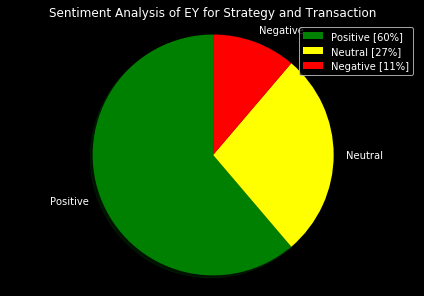

In [4]:
get_tweet_sentiment(df,"EY","Strategy and Transaction")

{'#strategy': 58, '#KPMG': 43, '#AI': 29, '#innovation': 28, '#data': 20}


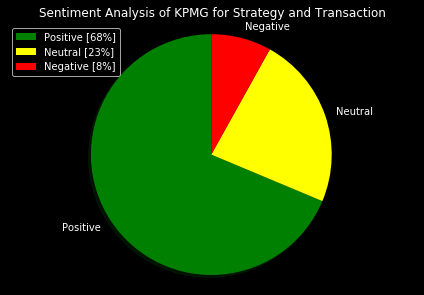

In [5]:
df=pd.read_csv("Services/KPMG_Strategy&Transactions.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"KPMG","Strategy and Transaction")

{'#strategy': 22, '#AI': 19, '#PwC': 15, '#VR': 15, '#cybersecurity': 14}


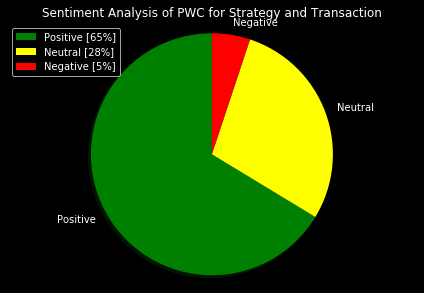

In [6]:
df=pd.read_csv("Services/PWC_Strategy&Transactions.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"PWC","Strategy and Transaction")

{'#strategy': 56, '#AI': 17, '#innovation': 17, '#cloud': 17, '#leadership': 16}


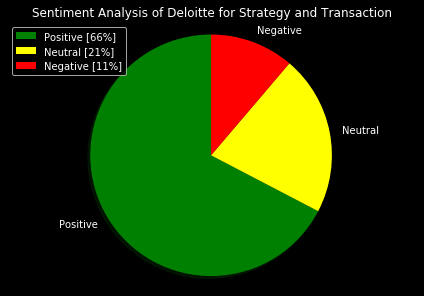

In [7]:
df=pd.read_csv("Services/Deloitte_Strategy&Transactions.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"Deloitte","Strategy and Transaction")

In [8]:
#Top hashtags to EY
'''
#strategy
#AI
#innovation
#automative
#data
#cloud
#leadership
#VR
#cybersecurity
#BetterWorkingWorld
'''

'\n#strategy\n#AI\n#innovation\n#automative\n#data\n#cloud\n#leadership\n#VR\n#cybersecurity\n#BetterWorkingWorld\n'

{'#EY': 16, '#Brexit': 8, '#Consultancy': 8, '#COVID19': 5, '#consultancy': 5}


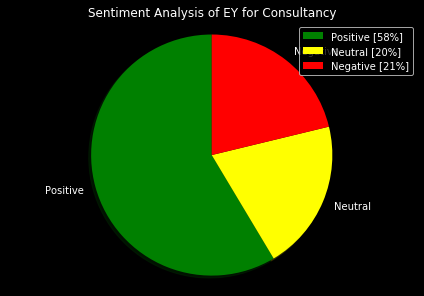

{'#pwcproud': 24, '#GIR’s': 24, '#PwC': 13, '#bejobs': 5, '#legaljobs': 4}


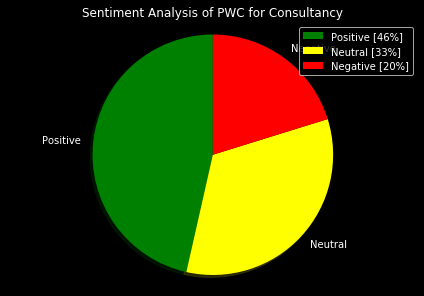

{'#cybersecurity': 9, '#consultancy': 6, '#KPMG': 5, '#Deloitte': 3, '#influence': 2}


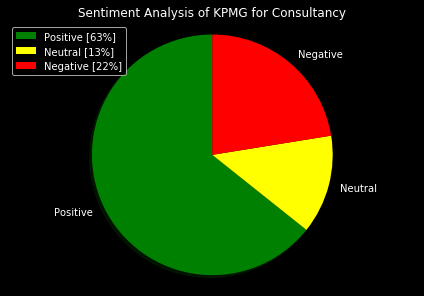

{'#Deloitte': 12, '#AI': 7, '#technology': 6, '#COVID19': 5, '#consultancy': 5}


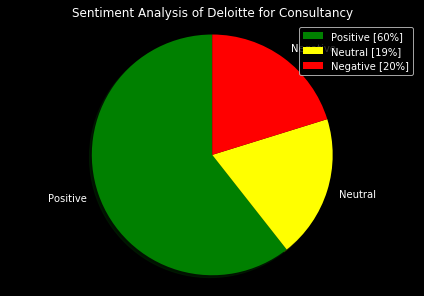

In [9]:
#for Consultancy
df=pd.read_csv("Services/EY_Consult.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"EY","Consultancy")

df=pd.read_csv("Services/PWC_Consultancy.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"PWC","Consultancy")


df=pd.read_csv("Services/KPMG_Consultancy.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"KPMG","Consultancy")


df=pd.read_csv("Services/Deloitte_Consultancy.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"Deloitte","Consultancy")




In [10]:
#Top hashtags used for Consultancy
'''
#consultancy
#AI
#technology
#Gir's
#COVID
#cybersecurity
'''

"\n#consultancy\n#AI\n#technology\n#Gir's\n#COVID\n#cybersecurity\n"

{'#EY': 35, '#apprenticeships': 15, '#Assurance': 14, '#BetterWorkingWorld': 13, '#assurance': 10}


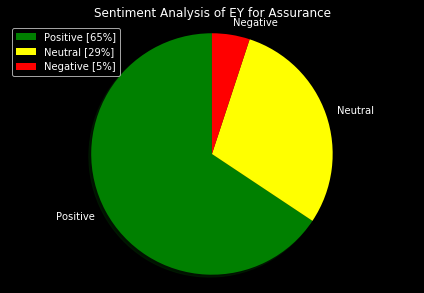

{'#assurance': 42, '#AuditorProud.': 23, '#PwC': 22, '#hiring': 17, '#teampwc': 15}


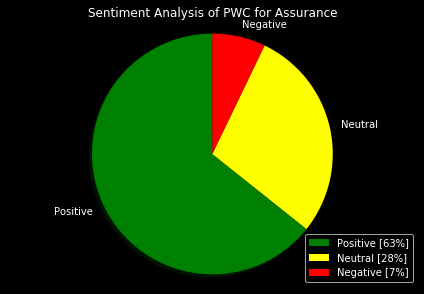

{'#ESG': 32, '#Audit': 30, '#KPMG': 29, '#Assurance': 21, '#Sustainability': 20}


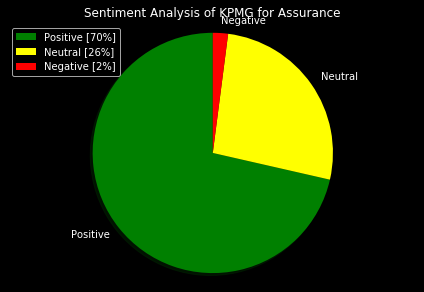

{'#Deloitte': 11, '#Assurance': 9, '#Audit': 9, '#flexibleworking': 6, '#assurance': 4}


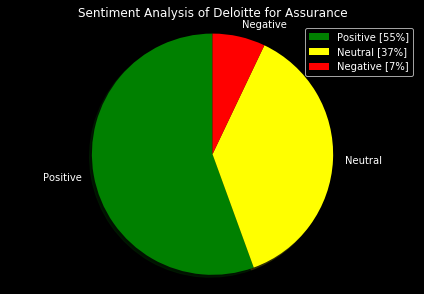

In [11]:
#for Assurance
df=pd.read_csv("Services/EY_Assurance.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"EY","Assurance")

df=pd.read_csv("Services/PWC_Assurance.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"PWC","Assurance")


df=pd.read_csv("Services/KPMG_Assurance.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"KPMG","Assurance")


df=pd.read_csv("Services/Deloitte_Assurance.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"Deloitte","Assurance")




In [12]:
#Top hashtags to Assurance
'''
#Assurance
#Audit
#flexible working
#Sustainability
#ESG
#hiring
#AuditorProud
#apprenticeships
#BetterWorkingWorld
'''

'\n#Assurance\n#Audit\n#flexible working\n#Sustainability\n#ESG\n#hiring\n#AuditorProud\n#apprenticeships\n#BetterWorkingWorld\n'

{'#tax': 438, '#EY': 160, '#Tax': 135, '#COVID19': 79, '#BetterWorkingWorld': 78}


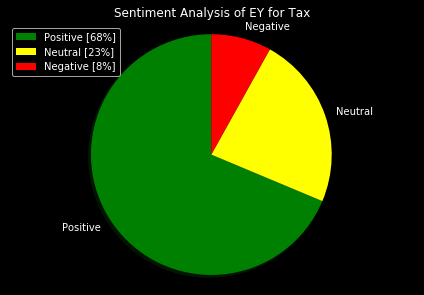

{'#tax': 57, '#Tax': 24, '#Election2020.': 19, '#Election2020': 17, '#PwC': 17}


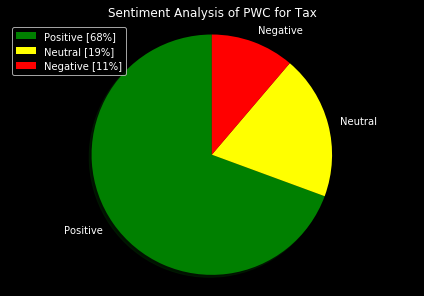

{'#KPMGTax': 75, '#KPMG': 45, '#tax': 35, '#Tax': 31, '#PostElection': 25}


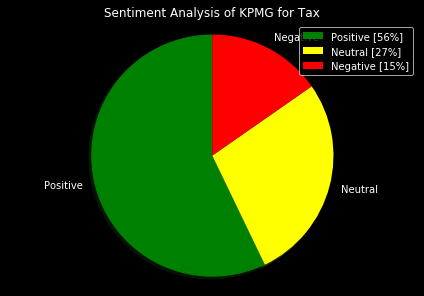

{'#tax': 167, '#Tax': 41, '#internationaltax': 26, '#transferpricing': 25, '#beps': 24}


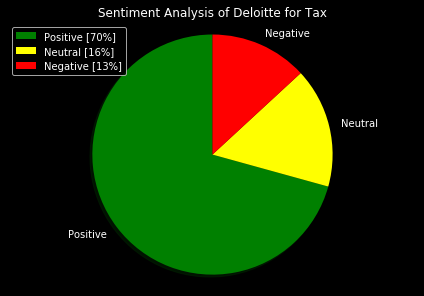

In [13]:
#for TAX
df=pd.read_csv("Services/EY_Tax.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"EY","Tax")

df=pd.read_csv("Services/PWC_Tax.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"PWC","Tax")


df=pd.read_csv("Services/KPMG_Tax.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"KPMG","Tax")


df=pd.read_csv("Services/Deloitte_Tax.csv")
df.fillna(0,inplace=True)
df["likeCount"]=df["likeCount"].astype("float64")
df.drop(["UserName","TwitterID"],axis=1,inplace=True)
df["mention"]=df["Text"].apply(findmention)
df["Hashtag"]=df["Text"].apply(findhashtag)
clean_tweet_texts = []
for i in range(len(df)):
    clean_tweet_texts.append(tweet_cleaner_updated(df["Text"][i]))
df["cleanText"]=clean_tweet_texts
getMaxHashtag=getmaxhashtags(df)
print(getMaxHashtag)
get_tweet_sentiment(df,"Deloitte","Tax")




In [ ]:
#Top hashtags to TAX
'''
#Tax
#internationaltax
#transferpricing
#beps
#COVID19
#BetterWorkingWorld
#Election2020
'''